# TP53 Methods - Sweep of Clinical Data

### Following our protein analysis, we looked for any correlations within our clinical data that were worth exploring.

### Standard imports, including CTPAC package

In [47]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import math
import seaborn as sns
import CPTAC

### Set up initial dataframes and variables

In [46]:
gene = 'TP53'
protein = 'TP53'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
clinical_full = CPTAC.get_clinical() 

# A listof mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.S241del', 'p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Patient_Id']

loc_compare = CPTAC.compare_mutations(proteomics, protein, gene)

clinical_full = clinical_full.join(loc_compare)
clinical_full = clinical_full.loc[clinical_full['Patient_Type'] == 'Tumor']

clinical_full = clinical_full.set_index('Proteomics_Participant_ID')
# Designating the type of TP53 mutation as a TP53 mutation not in the hotspot (False), within the hotspot (True) and no mutation (WT) 
clinical_full['Within_Hotspot'] = False
clinical_full.loc[hotspot_patients, 'Within_Hotspot'] = True
clinical_full.loc[clinical_full['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'WT'

## Clinical Data Chi-Square Analysis

### Bonferroni correction of p-value significance cuttoff for chi-square analysis

In [19]:
# calculating the number of Chi-Square analyses to be run based on data type
Chi_Tests = 0
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'object':
        Chi_Tests += 1
pcutoff = 0.05/Chi_Tests
print ('p-value cutoff is ' + str(pcutoff))           

p-value cutoff is 0.0007936507936507937


### Running the Chi_Square Analysis

In [30]:
# Go through every column of our clinical dataframe
for feature in clinical_full:
    # Only perform the chi-square analysis on columns with the data type of 'object'
    if str(clinical_full[feature].dtypes) == 'object':
        # creation of the table to be used in the chi-square analysis
        chi_clinical = pd.crosstab(clinical_full[feature], clinical_full['Within_Hotspot'])
        chi_test = scipy.stats.chi2_contingency(observed = chi_clinical)
        if str(feature) != 'Within_Hotspot':
            # Print significant values and the table used to run the chi-square analysis
            if chi_test[1] <= pcutoff:
                print(feature)
                print ('p-value = ' + str(chi_test[1]))
                chi_test = pd.crosstab(clinical_full[feature], clinical_full['Within_Hotspot'])
                print (str(chi_test) + '\n')

Histologic_type
p-value = 3.380768455237439e-10
Within_Hotspot   False  True  WT
Histologic_type                 
Carcinosarcoma       1     1   1
Clear cell           1     0   0
Endometrioid         4     5  76
Serous               5     6   0

p53
p-value = 4.116152318250829e-05
Within_Hotspot        False  True  WT
p53                                  
Cannot be determined      7     8  68
Loss of expression        2     0   0
Normal                    1     1   5
Overexpression            0     3   1
Unknown                   0     0   2

CNV_clustering
p-value = 5.162824073264053e-12
Within_Hotspot  False  True  WT
CNV_clustering                 
CNV-high            8     9   4
CNV-low             2     3  71

Mutation
p-value = 5.1245812424676625e-26
Within_Hotspot     False  True  WT
Mutation                          
Frame_Shift_Del        2     0   0
Frame_Shift_Ins        1     0   0
In_Frame_Del           0     1   0
Missense_Mutation      4    10   0
Nonsense_Mutation     

# Clinical Data t-Test Analysis

### Bonferroni correction of p-value significance cuttoff for chi-square analysis

In [31]:
# calculating the number of Chi-Square analyses to be run based on data type
t_tests = 0
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'float64' or str(clinical_full[feature].dtypes) == 'int64':
        t_tests += 1
pcutoff = 0.05/t_tests
print ('p-value cutoff is ' + str(pcutoff))

p-value cutoff is 0.0004901960784313725


In [42]:
# creating dataframes for the Tp53 hotspot mutations vs. wildtype TP53 comparison
TP53_Hotspot_Mutation = clinical_full.loc[clinical_full['Within_Hotspot'] == True]
Wildtype_TP53 = clinical_full.loc[clinical_full['Within_Hotspot'] != 'WT']

# TP53 Hotspot Mutations vs. Wildtype TP53 t-test
significant_results = 0
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'float64' or str(clinical_full[feature].dtypes) == 'int64':
        ttest = scipy.stats.ttest_ind(TP53_Hotspot_Mutation[feature].dropna(axis=0), Wildtype_TP53[feature].dropna(axis = 0))
        # Printing significant values
        if ttest[1] <= pcutoff:
            significant_results += 1
            print(feature)
            print('p-value = ' + str(ttest[1]))
            print('t-test statistic = ' + str(ttest[0]) + '\n')
if significant_results == 0:
    print('**There are no significant results based on this comparison**')
else:
    print('**There are ' + str(significant_results) + ' significant results based on this comparison**')

**There are no significant results based on this comparison**


In [41]:
# Creating dataframes for the Mutated TP53 vs Wildtype TP53 comparison        
Wildtype_TP53 = clinical_full.loc[clinical_full['Within_Hotspot'] == 'WT']
Mutated_TP53 = clinical_full.loc[clinical_full['Within_Hotspot'] != 'WT']

# Mutated TP53 vs. Wildtype TP53 t-test
significant_results = 0
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'float64' or str(clinical_full[feature].dtypes) == 'int64':
        ttest = scipy.stats.ttest_ind(Mutated_TP53[feature].dropna(axis=0), Wildtype_TP53[feature].dropna(axis = 0))
        # Printing significant values
        if ttest[1] <= pcutoff:
            significant_results += 1
            print(feature)
            print('p-value = ' + str(ttest[1]))
            print('t-test statistic = ' + str(ttest[0]) + '\n')
if significant_results == 0:
    print('**There are no significant results based on this comparison**')
else:
    print('**There are ' + str(significant_results) + ' significant results based on this comparison**') 

LVSI
p-value = 3.100302642560359e-05
t-test statistic = 4.373790901875431

Estrogen_Receptor_%
p-value = 0.0004717873744776047
t-test statistic = -3.856544626291203

Pathway_activity_JAK.STAT
p-value = 4.528219552713036e-07
t-test statistic = 5.414651489765074

Pathway_activity_p53
p-value = 3.342047697282348e-06
t-test statistic = -4.936953813700532

TP53_TP53
p-value = 0.0
t-test statistic = inf

TP53_pathway
p-value = 3.706334980139393e-23
t-test statistic = 13.049989357168926

PI3K_PTEN
p-value = 5.927394041381181e-10
t-test statistic = -6.87094689710222

PI3K_pathway
p-value = 2.3484671470823606e-05
t-test statistic = -4.441548117153734

Mutation_signature_C>G
p-value = 1.6352515297635472e-10
t-test statistic = 7.1416247038389775

Mutation_signature_C>T
p-value = 7.2891360726446605e-06
t-test statistic = -4.738498145204556

TP53
p-value = 1.7272440363208252e-07
t-test statistic = 5.68914108135854

**There are 11 significant results based on this comparison**


## Plotting columns from the clinical data found to be significant

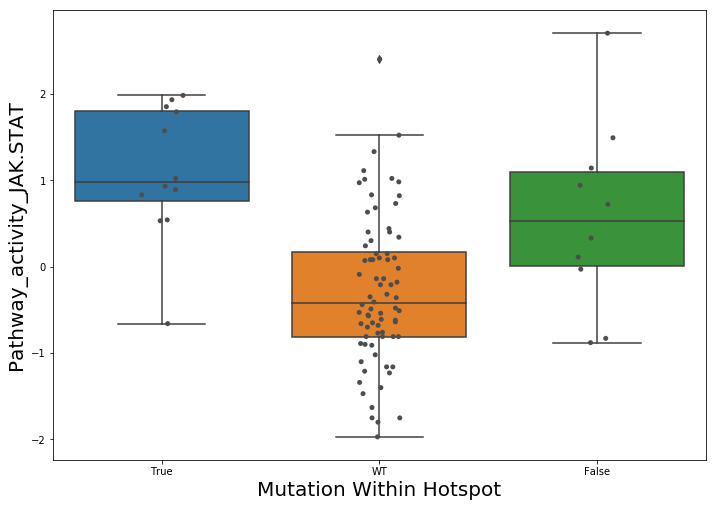

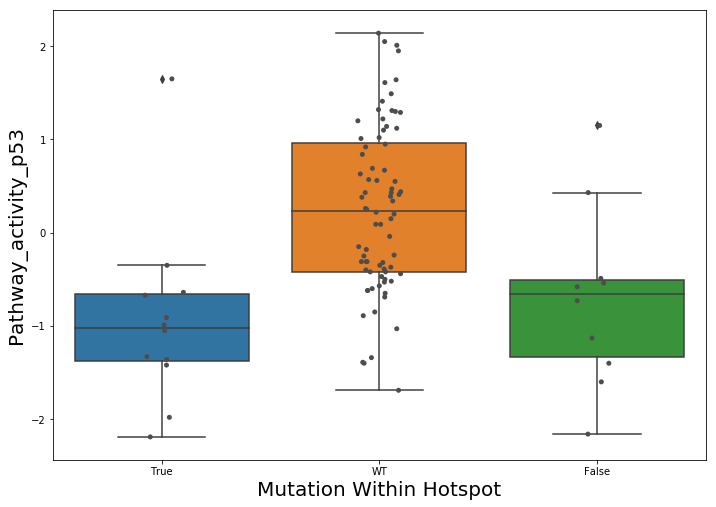

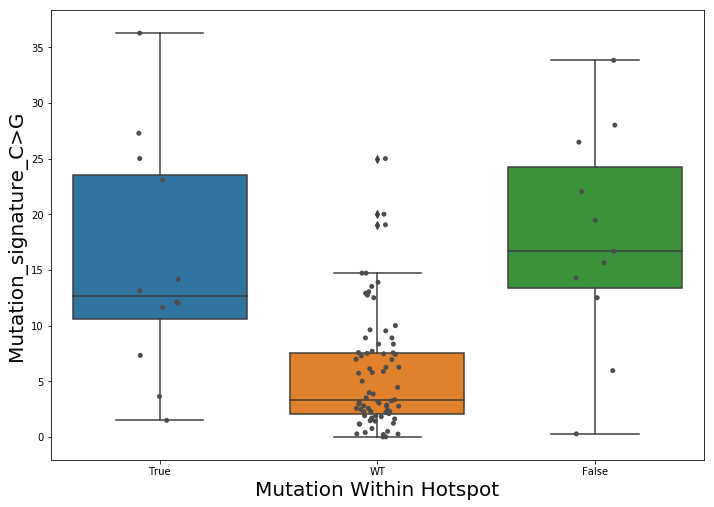

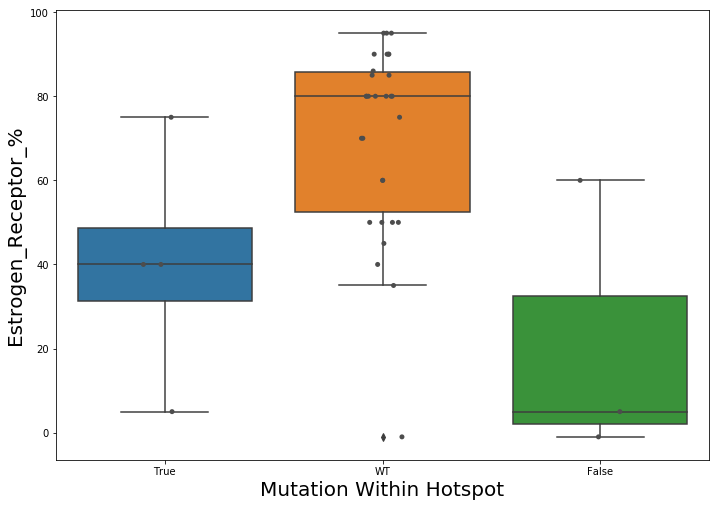

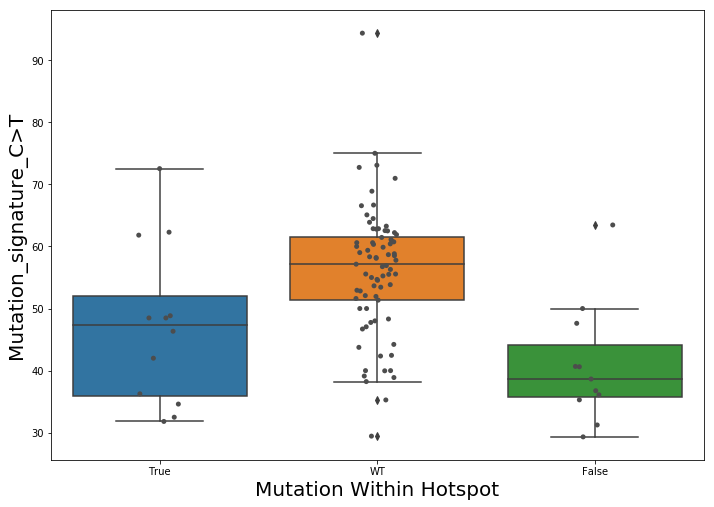

In [43]:
# We compiled this list of 5 clinical data columns based on which data was able to be plotted
sig_list = ['Pathway_activity_JAK.STAT', 'Pathway_activity_p53', 'Mutation_signature_C>G', 'Estrogen_Receptor_%', 'Mutation_signature_C>T']

# Plotting each of the clinical data columns from our list
for feature in sig_list:
    Y_var = feature
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize = a4_dims)
    boxplt = sns.boxplot(data = clinical_full, x = 'Within_Hotspot', y = Y_var, ax = ax)
    boxplt = sns.stripplot(data = clinical_full, x = 'Within_Hotspot', y = Y_var, jitter = True, color = '.3')
    boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
    boxplt.set_ylabel(Y_var, fontsize='20')
    plt.show()